In [11]:
import xarray as xr
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn_som.som import SOM
import salishsea_tools.viz_tools as sa_vi
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import os

In [12]:
# Dataset and date
ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/20mar22/SalishSea_1d_20220320_20220320_grid_T.nc')
ds_bio = xr. open_dataset ('/results2/SalishSea/nowcast-green.202111/20mar22/SalishSea_1d_20220320_20220320_biol_T.nc')
date = pd.DatetimeIndex(ds['time_counter'].values)

# Driver variables
temp = ds.votemper
saline = ds.vosaline
e3t = ds.e3t

# Biological variables
sil = ds_bio.silicon
nitr = ds_bio.nitrate
ammo = ds_bio.ammonium

# Phytoplankton variables
flag = ds_bio.flagellates
diat = ds_bio.diatoms

# Zooplankton variables
micro = ds_bio.microzooplankton
meso = ds_bio.mesozooplankton

# Open the mesh mask
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
mask = mesh.tmask.to_numpy()

# Applying the mask
temp = temp.where(mask==1)
saline = saline.where(mask==1)
e3t = e3t.where(mask==1)

sil = sil.where(mask==1)
nitr= nitr.where(mask==1)
ammo = ammo.where(mask==1)

flag = flag.where(mask==1)
diat = diat.where(mask==1)

micro = micro.where(mask==1)
meso = meso.where(mask==1)

# Integrating the variables
temp_i1 = (temp[0,0:15] * e3t[0,0:15]).sum('deptht', skipna = True, min_count = 15) / flag.deptht[14]
temp_i2 = (temp[0,15:27] * e3t[0,15:27]).sum('deptht', skipna = True, min_count = 12) / (flag.deptht[26] - flag.deptht[15])
saline_i1 = (saline[0,0:15] * e3t[0,0:15]).sum('deptht', skipna = True, min_count = 15) / flag.deptht[14]
saline_i2 = (saline[0,15:27] * e3t[0,15:27]).sum('deptht', skipna = True, min_count = 12) / (flag.deptht[26] - flag.deptht[15])

sil_i = (sil[0,0:27] * e3t[0,0:27]).sum('deptht', skipna = True, min_count = 27) / flag.deptht[26]
nitr_i = (nitr[0,0:27] * e3t[0,0:27]).sum('deptht', skipna = True, min_count = 27) / flag.deptht[26]
ammo_i = (ammo[0,0:27] * e3t[0,0:27]).sum('deptht', skipna = True, min_count = 27) / flag.deptht[26]

flag_i = (flag[0,0:27] * e3t[0,0:27]).sum('deptht', skipna = True, min_count = 27) / flag.deptht[26]
diat_i = (diat[0,0:27] * e3t[0,0:27]).sum('deptht', skipna = True, min_count = 27) / flag.deptht[26]

micro_i = (micro[0,0:27] * e3t[0,0:27]).sum('deptht', skipna = True, min_count = 27) / flag.deptht[26]
meso_i = (meso[0,0:27] * e3t[0,0:27]).sum('deptht', skipna = True, min_count = 27) / flag.deptht[26]



In [13]:
# Post processing 
inputs = np.stack([temp_i1.values.flatten(), temp_i2.values.flatten(), saline_i1.values.flatten(), saline_i2.values.flatten()])
indx = np.argwhere(~np.isnan(inputs[0]) & ~np.isnan(inputs[1]) & ~np.isnan(inputs[2])& ~np.isnan(inputs[3])) 
inputs2 = inputs[:,indx[:,0]]
inputs2 = inputs2.transpose()

targets= sil_i.values.flatten()
targets2 = targets[indx]
targets2 = np.ravel(targets2)

# Regressor
X_train, X_test, y_train, y_test = train_test_split(inputs2, targets2, random_state=1)
regr = MLPRegressor(solver = 'lbfgs', max_iter=200).fit(X_train, y_train)
output = regr.predict(inputs2)



# Post processing
indx2 = np.full(inputs[0,:].size,np.nan)
indx2[indx[:,0]] = output
modeled = np.reshape(indx2,(898,398)) 

# Preparation of the dataarray 
modeled = xr.DataArray(modeled,
                coords = {'y': diat_i.y, 'x': diat_i.x},
                dims = ['y','x'],
                attrs=dict(description="mole_concentration_of_diatoms_expressed_as_nitrogen_in_sea_water",
                            long_name ="Diatoms Concentration",
                            units="mmol m-2"),
                )

print ('The correlation coefficient is:', math.sqrt(regr.score(X_test, y_test)))
print(' The root mean square error is:', math.sqrt(mse(targets2,output)))

The correlation coefficient is: 0.9125954371518905
 The root mean square error is: 2.431057882392325


/home/ibougoudis/conda_envs/analysis-ilias/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


AttributeError: AxLine.set() got an unexpected keyword argument 'kwargs'

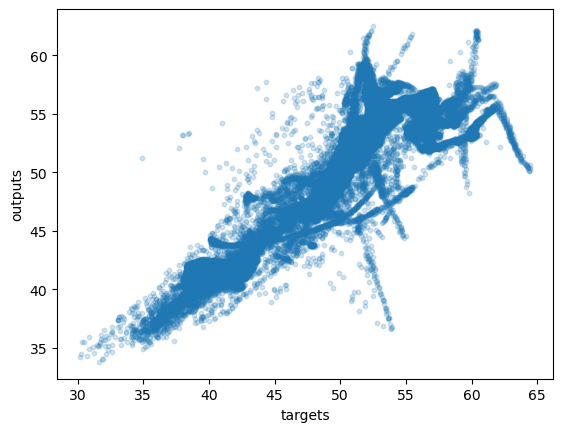

In [37]:
plt.scatter(targets2,output, alpha = 0.2, s = 10)
plt.xlabel('targets')
plt.ylabel('outputs')

# compute slope m and intercept b
m, b = np.polyfit(targets2, output, deg=1)

# plot fitted y = m*x + b
plt.axline(xy1=(0, b), slope=m, kwargs={'xdata':targets2}, color='r')

Text(0.5, 0.98, '2022/03/20')

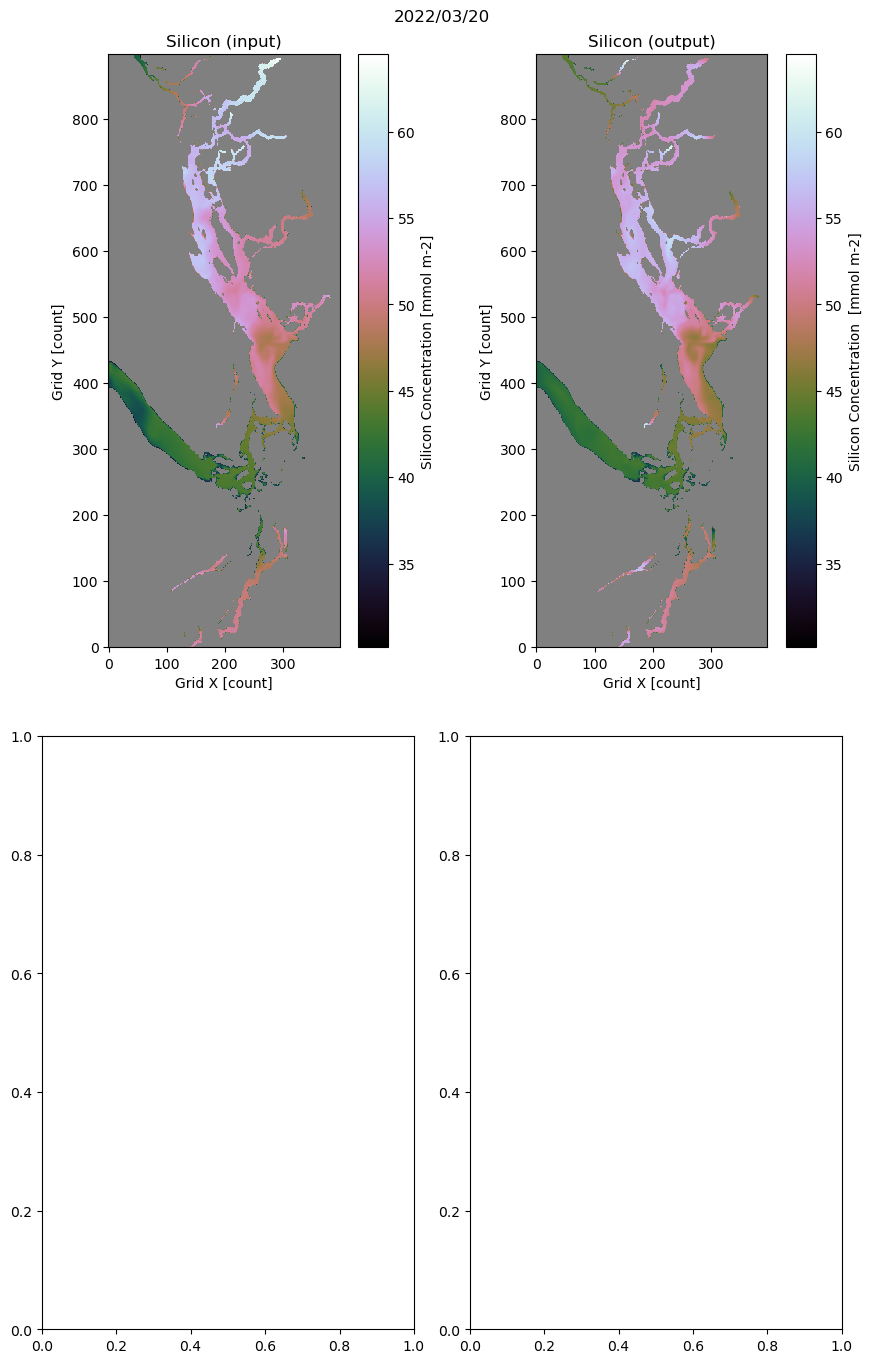

In [15]:
if date[0].month < 10:
    month = '0' + str(date[0].month)
else:
    month = str(date[0].month)

if date[0].day < 10:
    day = '0' + str(date[0].day)  
else:
    day = str(date[0].day) 

fig, ax = plt.subplots(2,2, figsize=(10, 15))

cmap = plt.get_cmap('cubehelix')
cmap.set_bad('gray')

test = sil_i.plot.pcolormesh(ax=ax[0,0], cmap=cmap, vmin = sil_i.min(), vmax = sil_i.max(), cbar_kwargs={'label': 'Silicon Concentration [mmol m-2]'})

modeled.plot.pcolormesh(ax=ax[0,1], cmap=cmap, vmin = sil_i.min(), vmax = sil_i.max(), cbar_kwargs={'label': 'Silicon Concentration  [mmol m-2]'})

plt.subplots_adjust(left=0.1,
    bottom=0.1, 
    right=0.9, 
    top=0.95, 
    wspace=0.15, 
    hspace=0.15)

sa_vi.set_aspect(ax[0,0])
sa_vi.set_aspect(ax[0,1])


ax[0,0].title.set_text('Silicon (input)')
ax[0,1].title.set_text('Silicon (output)')




fig.suptitle(str(date[0].year) + '/' + month + '/' + day)
